# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[2**9, 2**8, 2**7]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name=f"hidden_layer{i+1}")(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name=f"hidden_layer{i+1}")(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

W0727 21:29:34.850337 26256 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 21:29:35.269745 26256 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 21:29:35.396280 26256 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1, 1e-2]
EPOCHS = 15
BATCH_SIZE = 256
OPTIMIZER = [
    keras.optimizers.Adam,
    keras.optimizers.Adagrad,
    keras.optimizers.RMSprop,
    keras.optimizers.SGD,
]

In [7]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr, opt in itertools.product(LEARNING_RATE, OPTIMIZER):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Experiment with LR = {lr:.4f}, Optimizer = {opt}")
    model = build_mlp(input_shape=x_train.shape[1:])
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt(lr=lr))
    
    model.fit(x_train, 
              y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f"exp-lr-{lr}-optimizer-{opt}"
    results[exp_name_tag] = {'train_loss':train_loss,
                             'valid_loss':valid_loss,
                             'train_acc':train_acc,
                             'valid_acc':valid_acc}

W0727 21:29:41.358981 26256 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0727 21:29:41.360476 26256 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0727 21:29:41.521678 26256 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Experiment with LR = 0.1000, Optimizer = <class 'keras.optimizers.Adam'>


W0727 21:29:41.980333 26256 deprecation.py:323] From D:\python\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 18s 369us/step - loss: 14.4445 - acc: 0.1002 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/15
50000/50000 [==============================] - 8s 163us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/15
50000/50000 [==============================] - 7s 144us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/15
50000/50000 [==============================] - 8s 154us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/15
50000/50000 [==============================] - 7s 138us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/15
50000/50000 [==============================] - 7s 136us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/15
50000/50000 [==============================] - 7s 135us/step - loss: 14.5063 - acc: 0.1000 - val_l

50000/50000 [==============================] - 5s 104us/step - loss: 1.4360 - acc: 0.4900 - val_loss: 1.5223 - val_acc: 0.4517402 - ac
Epoch 12/15
50000/50000 [==============================] - 8s 157us/step - loss: 1.4056 - acc: 0.5038 - val_loss: 1.4993 - val_acc: 0.4626
Epoch 13/15
50000/50000 [==============================] - 7s 134us/step - loss: 1.3823 - acc: 0.5082 - val_loss: 1.6103 - val_acc: 0.4203.3
Epoch 14/15
50000/50000 [==============================] - 7s 134us/step - loss: 1.3622 - acc: 0.5148 - val_loss: 1.5175 - val_acc: 0.4600
Epoch 15/15
50000/50000 [==============================] - 5s 105us/step - loss: 1.3380 - acc: 0.5245 - val_loss: 1.5997 - val_acc: 0.4383
Experiment with LR = 0.0100, Optimizer = <class 'keras.optimizers.Adam'>
Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 8s 152us/step - loss: 14.4462 - acc: 0.0995 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/15
50000/50000 [====================

Epoch 6/15
50000/50000 [==============================] - 5s 97us/step - loss: 1.6999 - acc: 0.4035 - val_loss: 1.6911 - val_acc: 0.4025
Epoch 7/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.6770 - acc: 0.4094 - val_loss: 1.7288 - val_acc: 0.3953
Epoch 8/15
50000/50000 [==============================] - 6s 111us/step - loss: 1.6529 - acc: 0.4176 - val_loss: 1.7228 - val_acc: 0.3897
Epoch 9/15
50000/50000 [==============================] - 7s 132us/step - loss: 1.6313 - acc: 0.4248 - val_loss: 1.6575 - val_acc: 0.4079
Epoch 10/15
50000/50000 [==============================] - 6s 128us/step - loss: 1.6093 - acc: 0.4340 - val_loss: 1.6658 - val_acc: 0.4141
Epoch 11/15
50000/50000 [==============================] - 6s 112us/step - loss: 1.5972 - acc: 0.4384 - val_loss: 1.6614 - val_acc: 0.4078
Epoch 12/15
50000/50000 [==============================] - 6s 125us/step - loss: 1.5765 - acc: 0.4454 - val_loss: 1.6056 - val_acc: 0.4283
Epoch 13/15
50000/50000 [=======

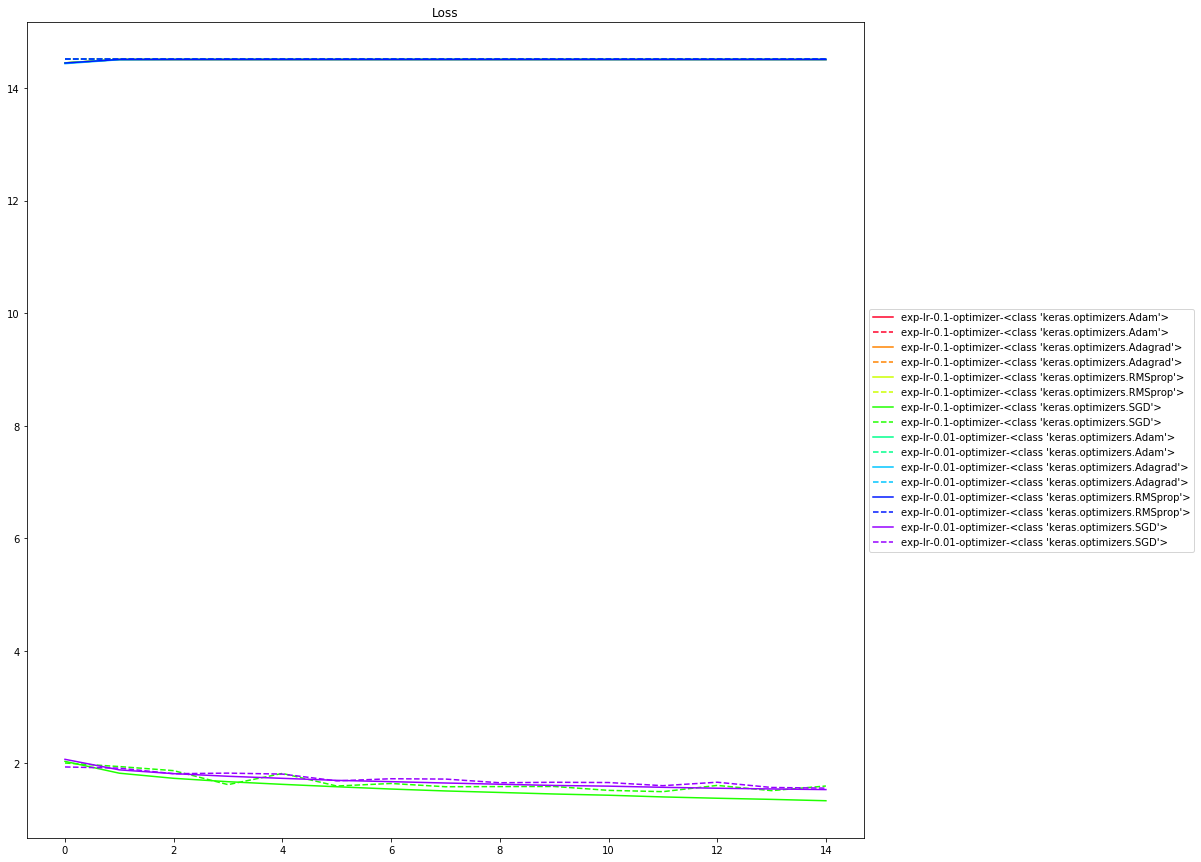

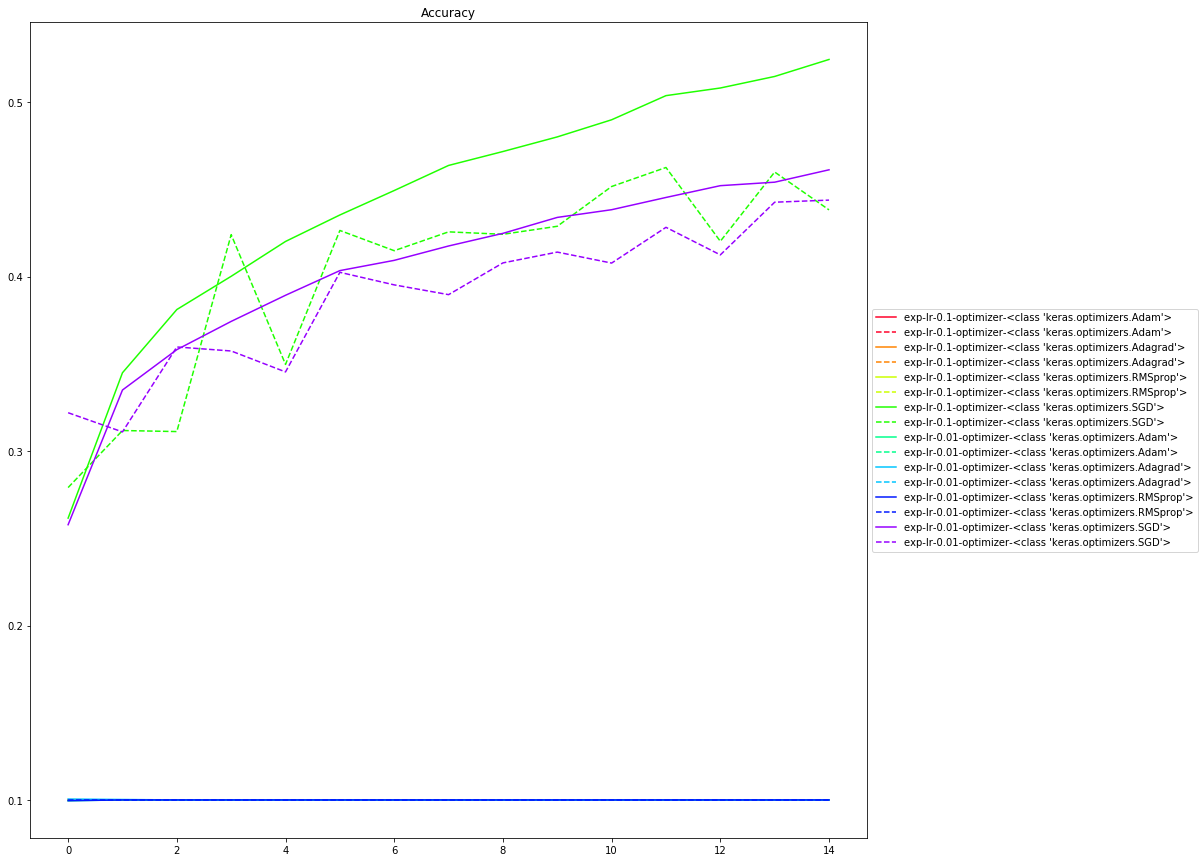

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(15, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(15, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()